In [2]:
import cv2
import numpy as np
import copy
import imutils
import matplotlib.pyplot as plt
import warnings
from google.colab.patches import cv2_imshow
from google.colab import drive
from scipy.spatial.distance import cdist
from imutils import contours

warnings.filterwarnings('ignore')

drive.mount('/content/gdrive')
path = ''

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load the image

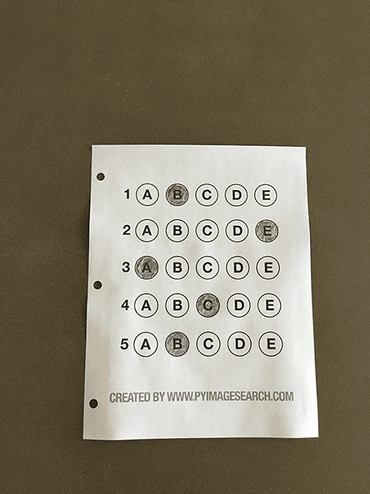

In [68]:
img = cv2.imread(path+'test.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

### Detection of a piece of paper

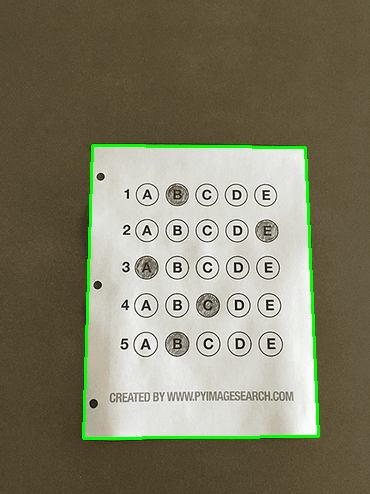

In [69]:
def find_sheet(gray):
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = cv2.Canny(blurred, 75, 200)
  # cv2_imshow(edged)
  cnts, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
  for cnt in cnts:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    if len(approx) == 4:
        test_cnt = approx
        break
  test_cnt[[1, 3], :] = test_cnt[[3, 1], :]
  return test_cnt
  
test_cnt = find_sheet(gray)
cv2_imshow(cv2.polylines(copy.copy(img), [test_cnt], True, (0,255,0), 2))

### Transformation of perspective

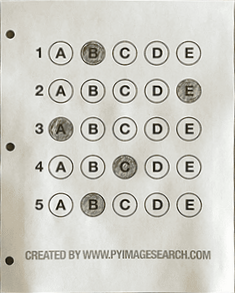

In [70]:
def perspective_transform(img, test_cnt):
  width = int(np.max(np.asanyarray([cdist(test_cnt[0], test_cnt[1], 'euclidean'), cdist(test_cnt[2], test_cnt[3], 'euclidean')])))
  height = int(np.max(np.asanyarray([cdist(test_cnt[0], test_cnt[3], 'euclidean'), cdist(test_cnt[1], test_cnt[2], 'euclidean')])))
  dst = np.array([[0, 0],
                  [width - 1, 0],
                  [width - 1, height - 1],
                  [0, height - 1]], dtype = np.float32)
  M = cv2.getPerspectiveTransform(np.squeeze(test_cnt, axis=1).astype(np.float32), dst)
  warped = cv2.warpPerspective(copy.copy(img), M, (width, height))
  return warped

warped = perspective_transform(img, test_cnt)
cv2_imshow(warped)

### Detection of contours of selected objects

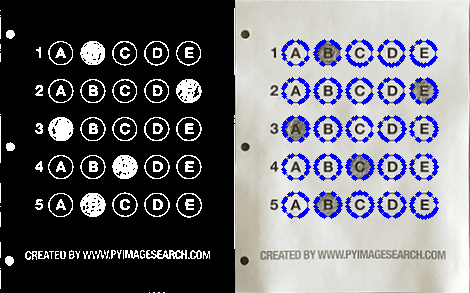

In [71]:
def find_answs_cnts(warped):
  threshed = cv2.threshold(cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  cnts = cv2.findContours(threshed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  question_cnts = []
  for cnt in cnts:
    (x, y, w, h) = cv2.boundingRect(cnt)
    ar = w / float(h)
    # print(ar, w, h)
    if w >= 20 and h >= 20 and ar >= 0.5 and ar <= 2:
      question_cnts.append(cnt)
  return threshed, question_cnts

threshed, question_cnts = find_answs_cnts(warped)
warped_copy = copy.copy(warped)
for cnt in question_cnts:
  cv2.drawContours(warped_copy, cnt, -1, (255, 0, 0), 3)
cv2_imshow(np.hstack((cv2.cvtColor(threshed, cv2.COLOR_GRAY2RGB), warped_copy)))

### Finding the marked objects

Zaznaczone odpowiedzi: ['B' 'E' 'A' 'C' 'B']



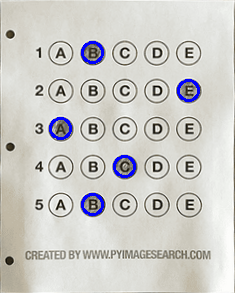

In [72]:
def find_marked_answs(threshed, warped, question_cnts):
  question_cnts = imutils.contours.sort_contours(question_cnts, method="right-to-left")[0]
  question_cnts = np.flip(np.asanyarray(question_cnts).reshape((5, 5)).T)

  questions = []
  for cnt in question_cnts.reshape(25):
    mask = np.zeros_like(threshed)
    cv2.drawContours(mask, [cnt], -1, 1, -1)
    mask = mask * threshed
    questions.append(cv2.countNonZero(mask))
  answs = np.argmax(np.array(questions).reshape((5, 5)), axis=1)
  labels = np.array(['A', 'B', 'C', 'D', 'E'])

  warped_copy = copy.copy(warped)
  for cnt in question_cnts[np.arange(0, 5), answs]:
    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv2.circle(warped_copy, (cX, cY), 10, (255, 0, 0), 2)
  print(f"Zaznaczone odpowiedzi: {labels[answs]}\n")
  return warped_copy

marked_answs_img = find_marked_answs(threshed, warped, question_cnts)
cv2_imshow(marked_answs_img)

### Testing the script on other images

In [73]:
def resize(img, template):
  scale = template.shape[0] / img.shape[0]
  dim = (int(img.shape[1] * scale), template.shape[0])
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def omr(path, filename):
  img = cv2.imread(path+filename)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  omr_flow = copy.copy(img)

  test_cnt = find_sheet(gray)
  omr_flow = np.hstack((omr_flow, cv2.polylines(copy.copy(img), [test_cnt], True, (0,255,0), 2)))

  warped = perspective_transform(img, test_cnt)
  omr_flow = np.hstack((omr_flow, resize(warped, img)))

  threshed, question_cnts = find_answs_cnts(warped)
  warped_copy = copy.copy(warped)
  for cnt in question_cnts:
    cv2.drawContours(warped_copy, cnt, -1, (255, 0, 0), 3)
  threshed_warped = np.hstack((cv2.cvtColor(threshed, cv2.COLOR_GRAY2RGB), warped_copy))
  omr_flow = np.hstack((omr_flow, resize(threshed_warped, img)))

  marked_answs_img = find_marked_answs(threshed, warped, question_cnts)
  omr_flow = np.hstack((omr_flow, resize(marked_answs_img, img)))
  cv2_imshow(omr_flow)

Zaznaczone odpowiedzi: ['C' 'E' 'A' 'B' 'B']



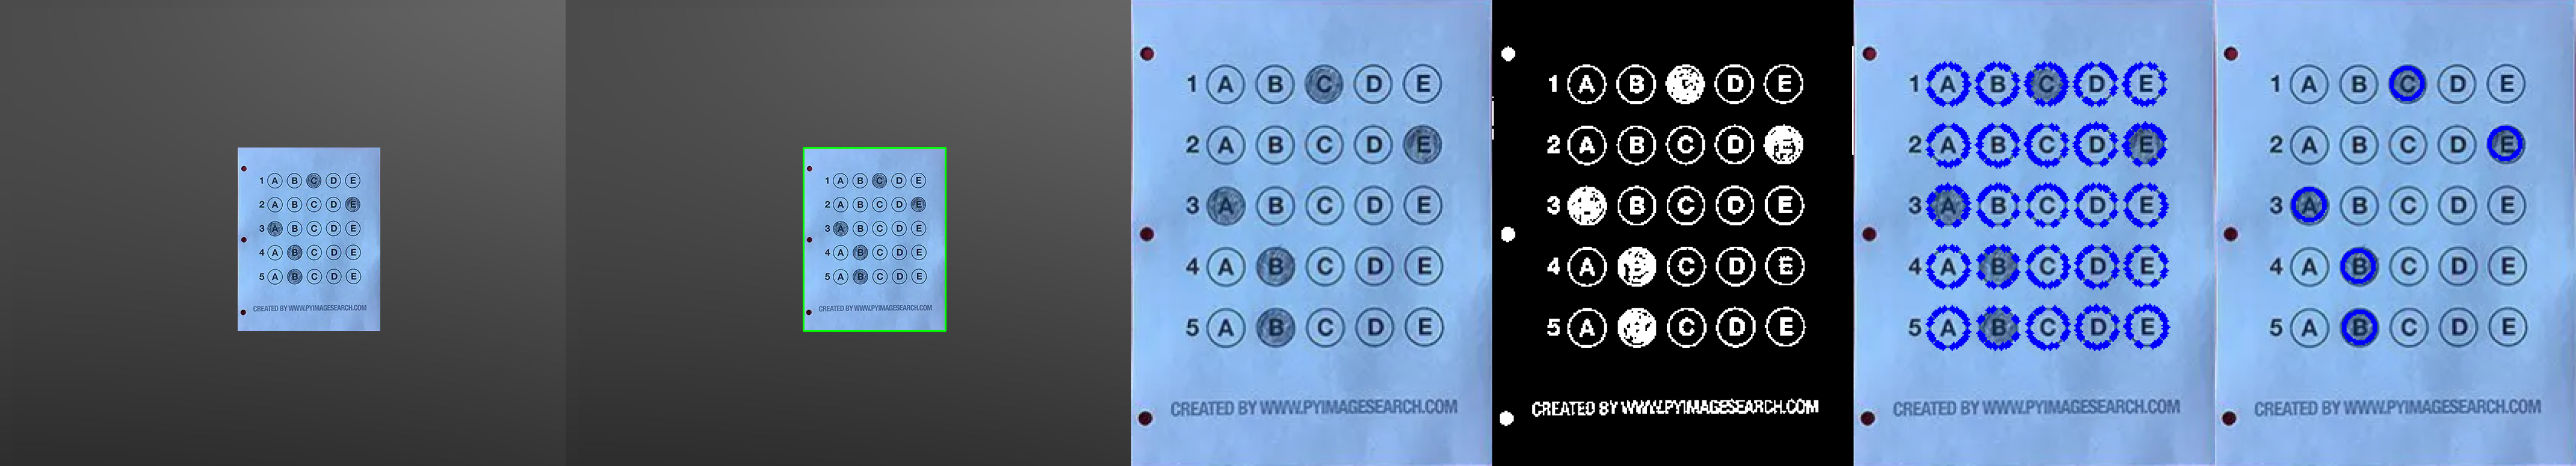

In [74]:
omr(path, 'test1.png')

Zaznaczone odpowiedzi: ['C' 'A' 'D' 'B' 'B']



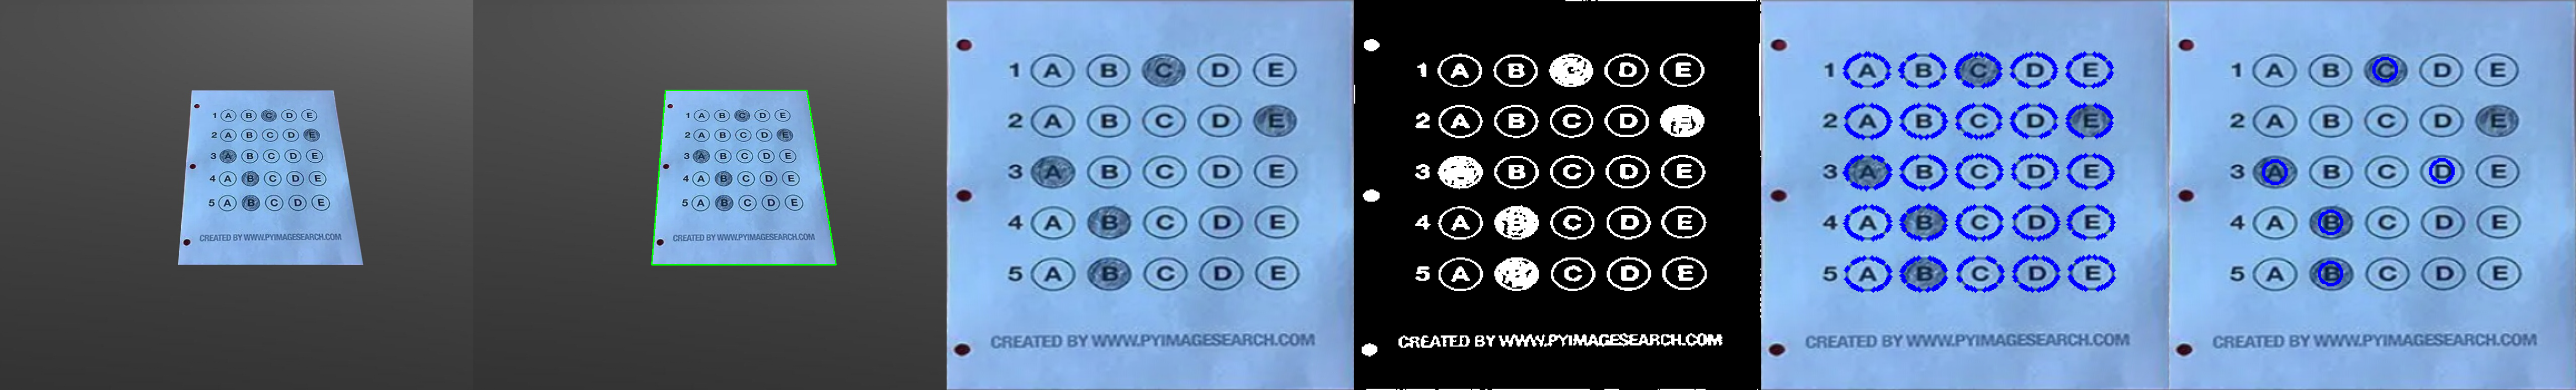

In [57]:
omr(path, 'test2.jpg')

Zaznaczone odpowiedzi: ['C' 'E' 'A' 'B' 'B']



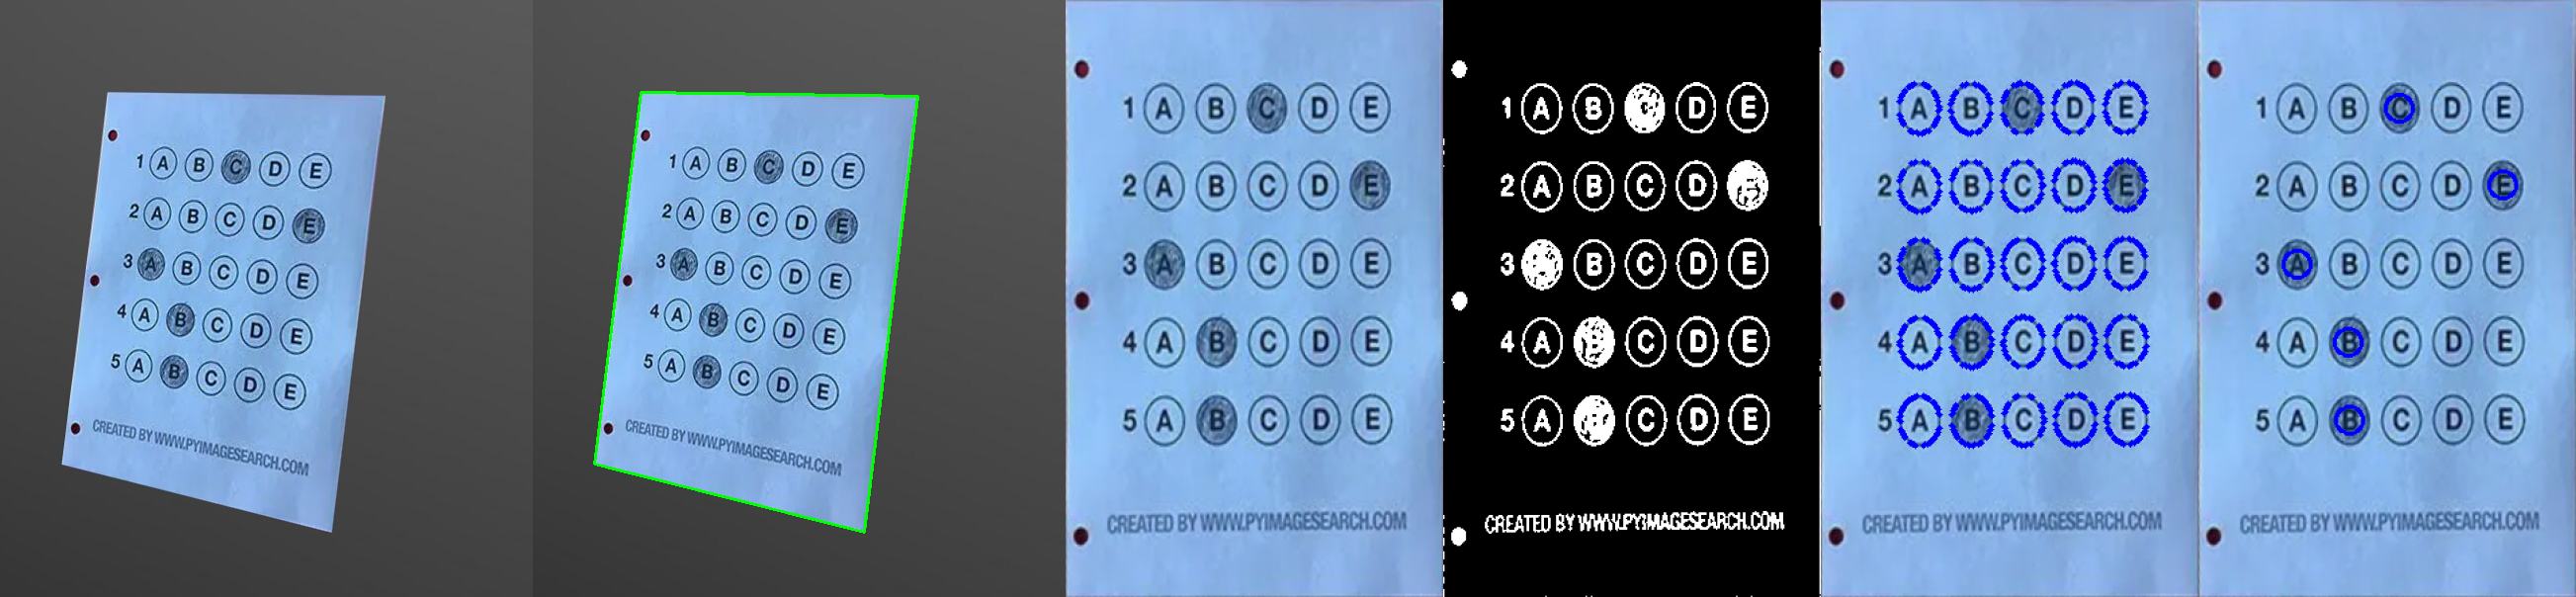

In [56]:
omr(path, 'test3.png')

Zaznaczone odpowiedzi: ['C' 'E' 'A' 'B' 'B']



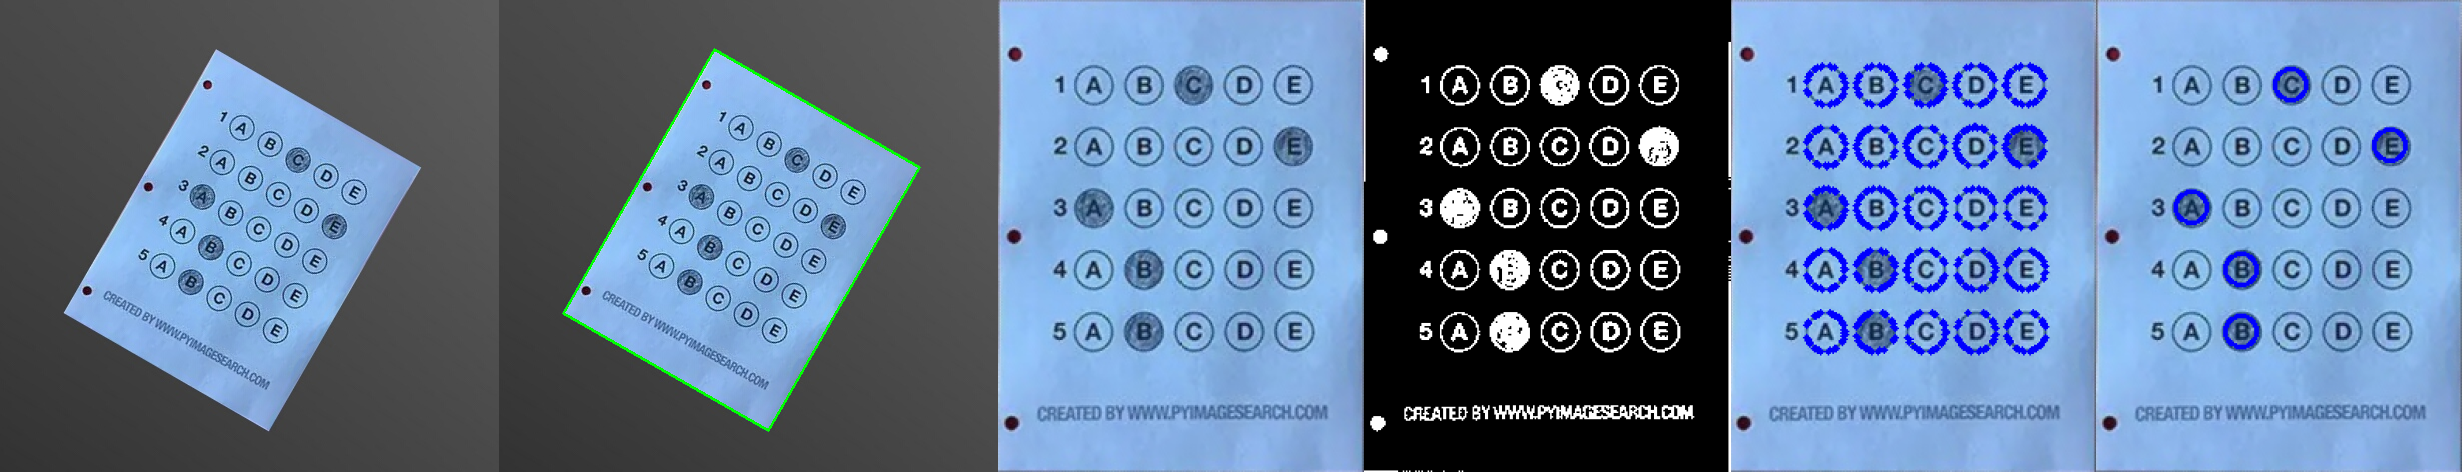

In [58]:
omr(path, 'test4.png')

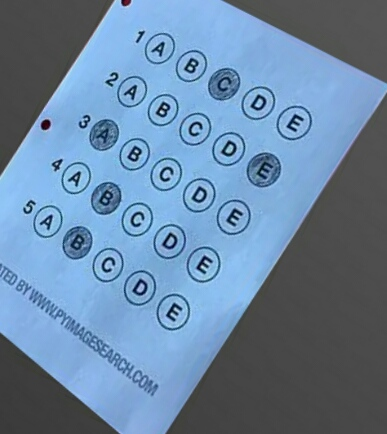

UnboundLocalError: ignored

In [65]:
cv2_imshow(cv2.imread(path+'test5.png'))
omr(path, 'test5.png')

##### The contour of the card (i.e. the four vertices) was not found

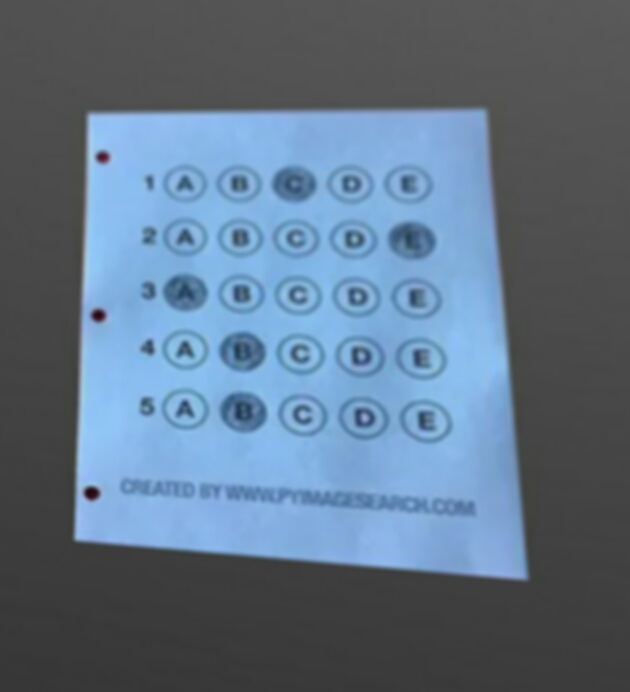

UnboundLocalError: ignored

In [64]:
cv2_imshow(cv2.imread(path+'test6.png'))
omr(path, 'test6.png')

##### The contour of the card (i.e. the four vertices) was not found

### Conclusions:
- During image testing there were problems with detecting stamp outlines, the problem was fixed by increasing the threshold.
- The problem with card detection for blurred images and with the card visible not in its entirety remained. Possible clipping by other means, but then the next step, which is perspective tranformation, will not be possible with the implemented method.
- With the angle of rotation and zooming out the script coped well, most of the answers were correctly marked.
- There were no difficulties with object recognition, although with more complex objects OMR can be supplemented in comparing objects to a pattern with the help of desctiptors such as shape.
- OMR is a simple and quick way to read forms, check for correctness of filling, etc.